In [1]:
import os
import sys

import astropy.units as u
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

from scipy.optimize.slsqp import approx_jacobian

project_path = "/Users/adrian/projects/kinematic-consensus/"
if project_path not in sys.path:
    sys.path.append(project_path)
import kingkong

In [167]:
# v = [-0.8218560647450601, -0.5578178790957554, -0.1157230426616782]
# theta = 3.9010707651854575
# q = kingkong.util.Quaternion.from_v_theta(v, theta)
q = None

np.random.seed(42)
# mock = kingkong.MockStream(r0=11., v0=0.8, nsteps_per_period=128,
#                            quaternion=q)
mock = kingkong.MockStream(r0=9., v0=0.5, nsteps_per_period=128,
                           quaternion=q)

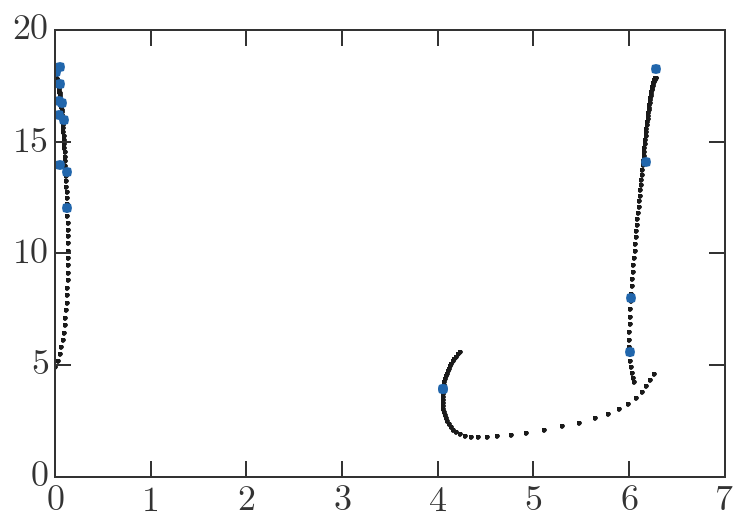

In [155]:
Y = kingkong.cartesian_to_spherical(kingkong.galactocentric_to_heliocentric(mock.X))
pl.plot(Y[:,0], Y[:,2], ls='none')
pl.plot(Y_obs[:,0], Y_obs[:,2], ls='none', marker='o')

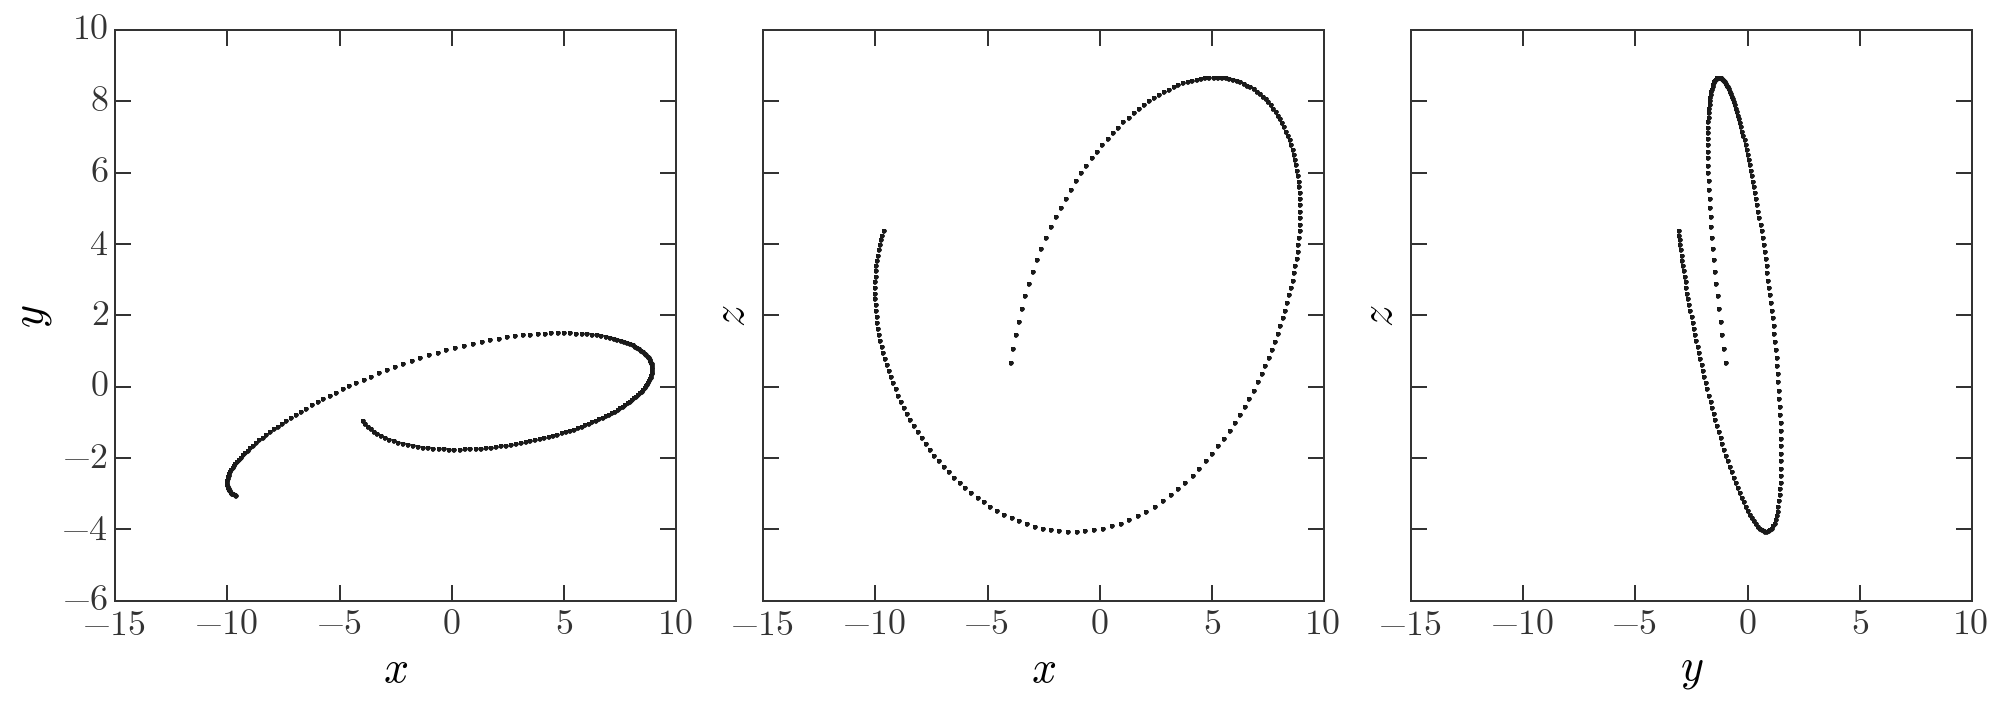

In [156]:
fig = mock.plot()

In [157]:
np.random.seed(42)
X_obs = mock.X[np.random.randint(len(mock.X), size=16)]
Y_obs = kingkong.cartesian_to_spherical(kingkong.galactocentric_to_heliocentric(X_obs))

V_obs = np.zeros_like(Y_obs)
V_obs[:,0] = 1E-5
V_obs[:,1] = 1E-5
V_obs[:,2] = 0.1 * Y_obs[:,2] # 10% distance error
V_obs[:,3] = (1*u.mas/u.yr).to(u.rad/u.Myr).value
V_obs[:,4] = (1*u.mas/u.yr).to(u.rad/u.Myr).value
V_obs[:,5] = (1*u.km/u.s).to(u.kpc/u.Myr).value
V_obs = V_obs**2.

Y_obs = np.random.normal(Y_obs, np.sqrt(V_obs))

In [172]:
xspread = 0.01
vspread = 0.001
VX = (np.array([xspread,xspread,xspread,vspread,vspread,vspread])*1.)**2
rootVX = np.sqrt(VX)
Xspread = np.random.normal(mock.X, np.sqrt(VX), size=(256,)+mock.X.shape)

In [159]:
Yspread = kingkong.cartesian_to_spherical(kingkong.galactocentric_to_heliocentric(Xspread))

In [160]:
func = lambda x: kingkong.cartesian_to_spherical(kingkong.galactocentric_to_heliocentric(x))

rootVY = np.zeros_like(Y)
for i in range(len(mock.X)):
    J = approx_jacobian(mock.X[i], func, 1E-4)
    cov = np.diag(VX)
    rootVY[i] = np.sqrt(np.diag(J.dot(cov).dot(J.T)))
VY = rootVY**2

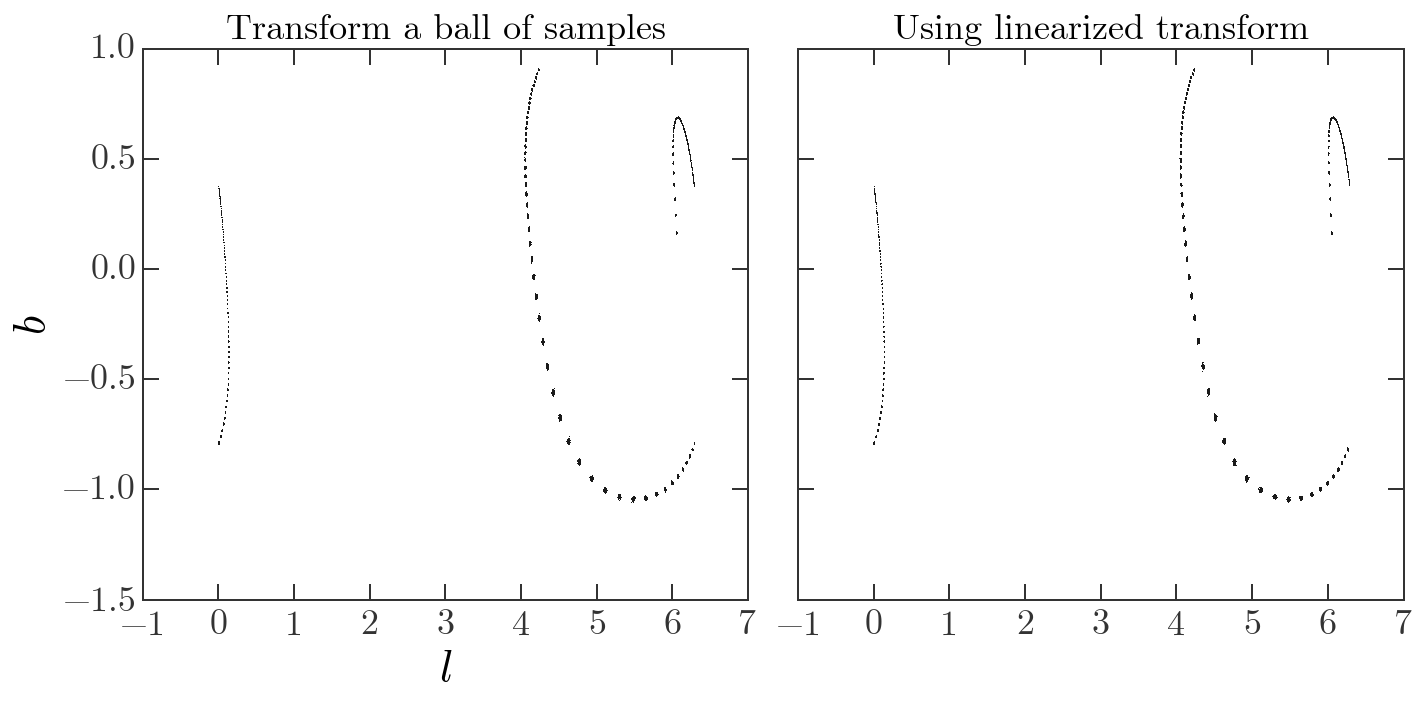

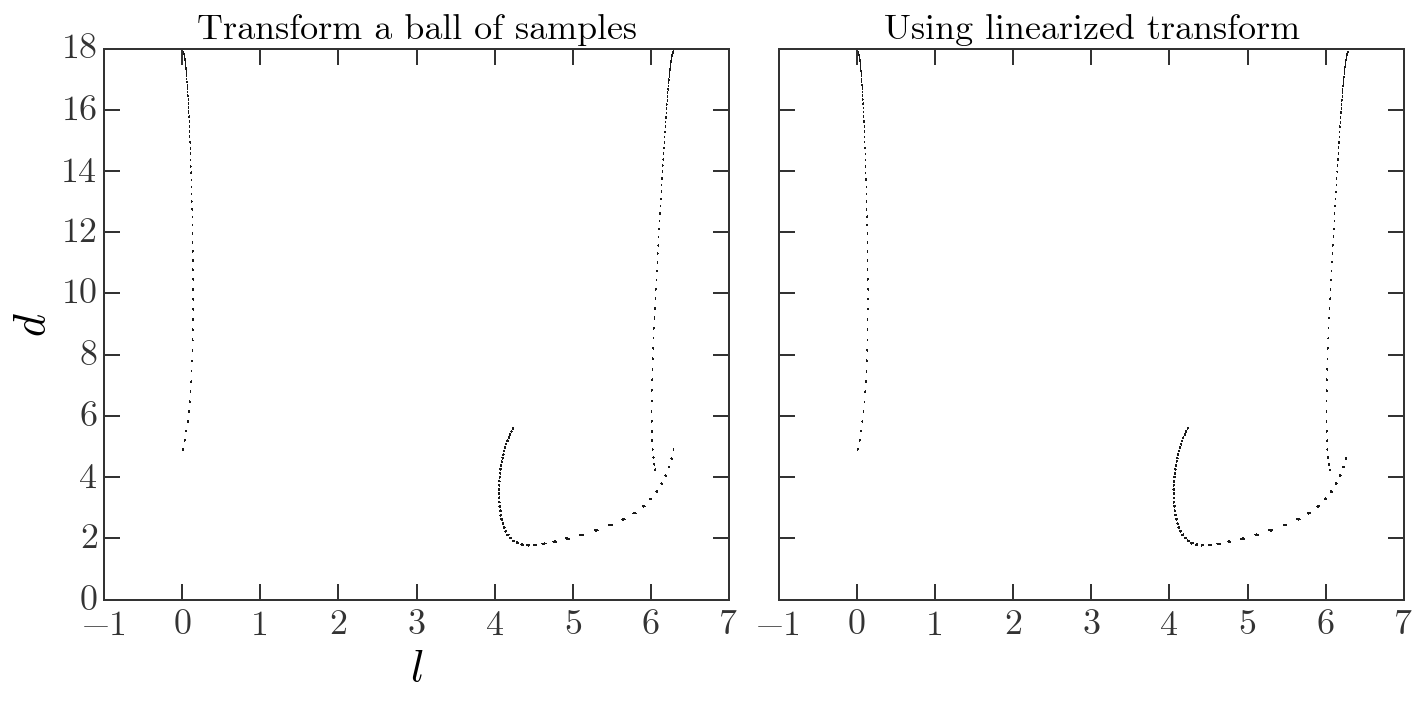

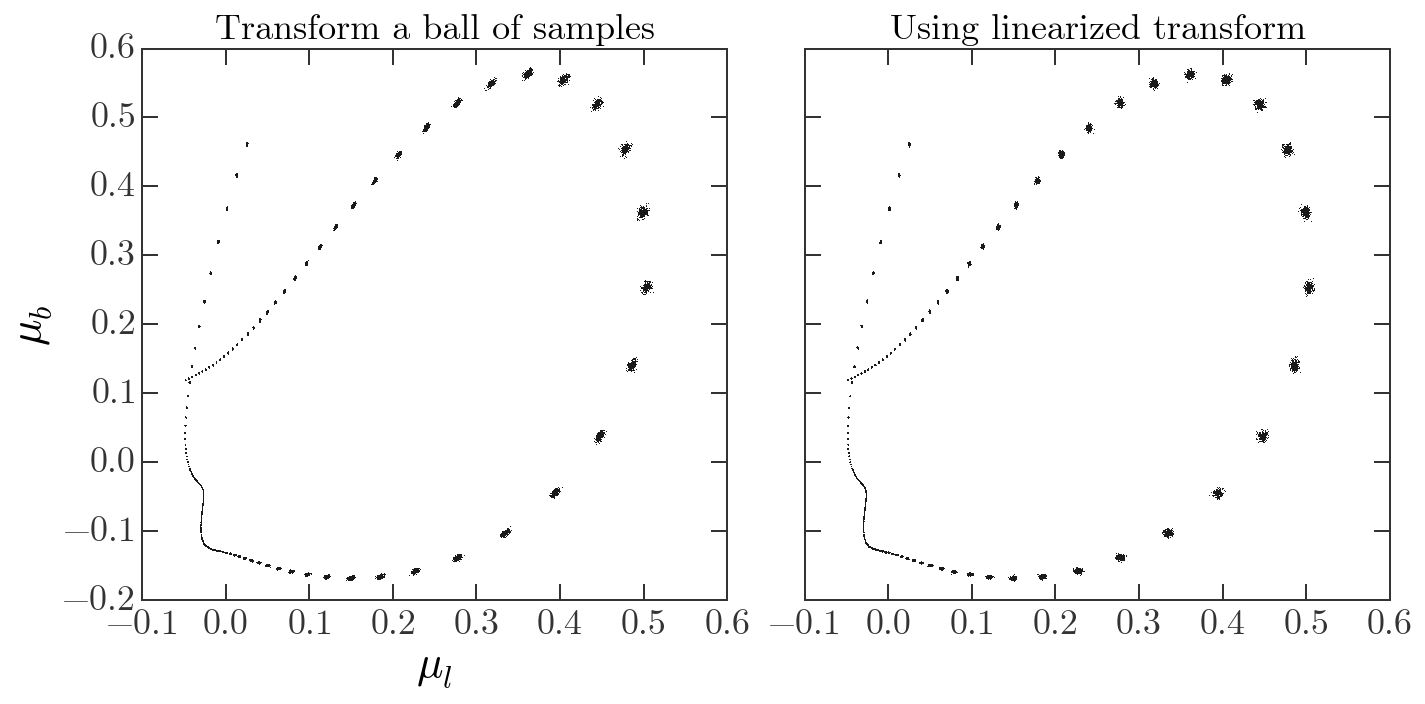

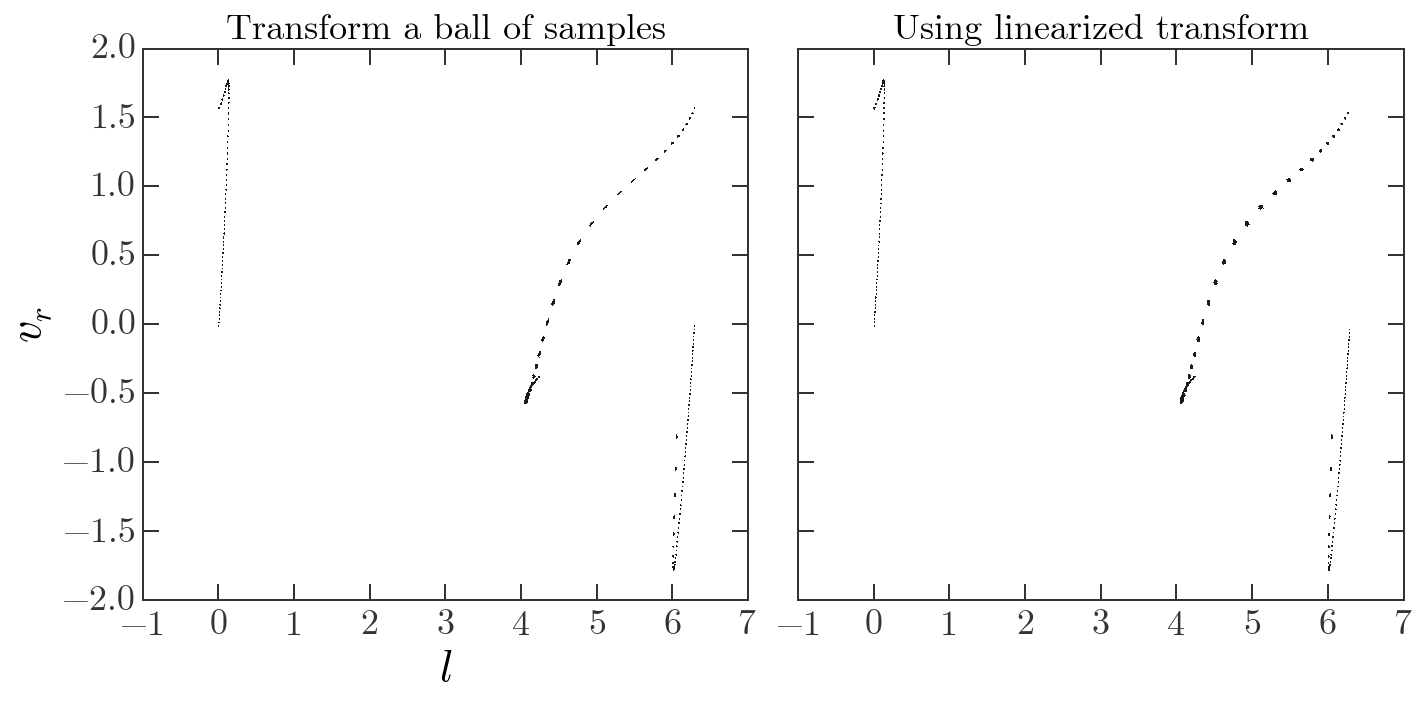

In [161]:
labels = [('$l$','$b$'), ('$l$','$d$'), (r'$\mu_l$',r'$\mu_b$'), ('$l$', '$v_r$')]
idxs = [(0,1), (0,2), (3,4), (0,5)]
ptkwargs = dict(alpha=1., marker=',', ls='none')

for (xl,yl),(ix1,ix2) in zip(labels, idxs):
    fig,axes = pl.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
    
    axes[0].plot(Yspread[...,ix1].ravel(), Yspread[...,ix2].ravel(), **ptkwargs)
#     pl.plot(Y[:,ix1] + 2*rootVY[:,ix1], Y[:,ix2] + 2*rootVY[:,ix2], marker=None, lw=1., color='r')
#     pl.plot(Y[:,ix1] - 2*rootVY[:,ix1], Y[:,ix2] - 2*rootVY[:,ix2], marker=None, lw=1., color='r')
    axes[0].set_xlabel(xl); axes[0].set_ylabel(yl)
        
    Yspread2 = np.random.normal(Y, rootVY, size=(256,)+Y.shape)
    axes[1].plot(Yspread2[...,ix1].ravel(), Yspread2[...,ix2].ravel(), **ptkwargs)
    
    axes[0].set_title("Transform a ball of samples", fontsize=18)
    axes[1].set_title("Using linearized transform", fontsize=18)
    fig.tight_layout()

Try to get something similar to "true" 1D variances with "rules of thumb"

In [175]:
sigmas = np.std(Yspread, axis=0)
sigmas.shape

(193, 6)

In [180]:
dumb_sigmas = np.zeros_like(sigmas)
dumb_sigmas[:,0] = xspread / Y[:,2]
dumb_sigmas[:,1] = xspread / Y[:,2]

(-1, 0)

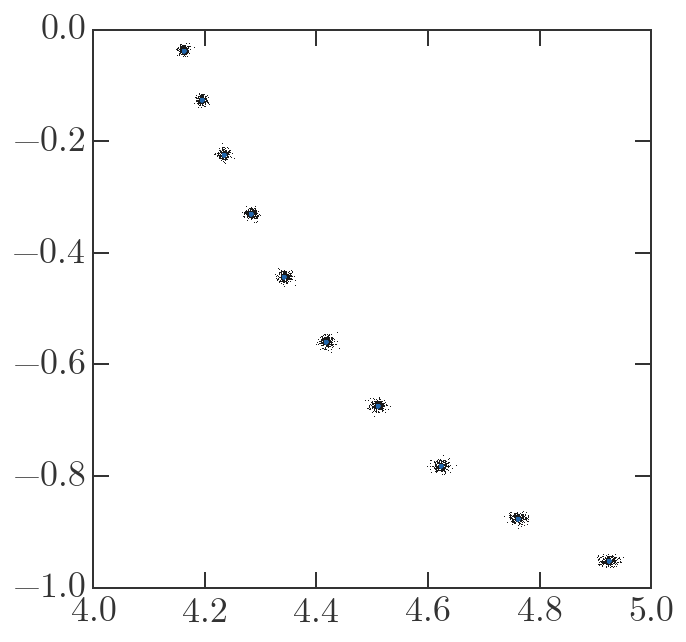

In [184]:
pl.figure(figsize=(5,5))
pl.plot(Yspread[...,0].ravel(), Yspread[...,1].ravel(), marker=',', ls='none')
pl.plot(Y[:,0], Y[:,1], ls='none')
pl.xlim(4,5)
pl.ylim(-1,0)

Now compute statistic

In [162]:
chisq_nk = np.sum(((Y[None] - Y_obs[:,None])**2.) / (VY[None] + V_obs[:,None]), axis=-1)
chisq_nk.shape

(16, 193)

In [163]:
chisq_nk.min(axis=1)

array([ 3.21914333,  3.16800114,  0.95319383,  0.70189791,  1.77375   ,
        7.11746551,  4.21871721,  6.64393112,  6.1428755 ,  1.21074764,
        5.00237627,  1.64188894,  7.44117899,  8.91147184,  2.69234351,
        1.28319739])

(-12, 12)

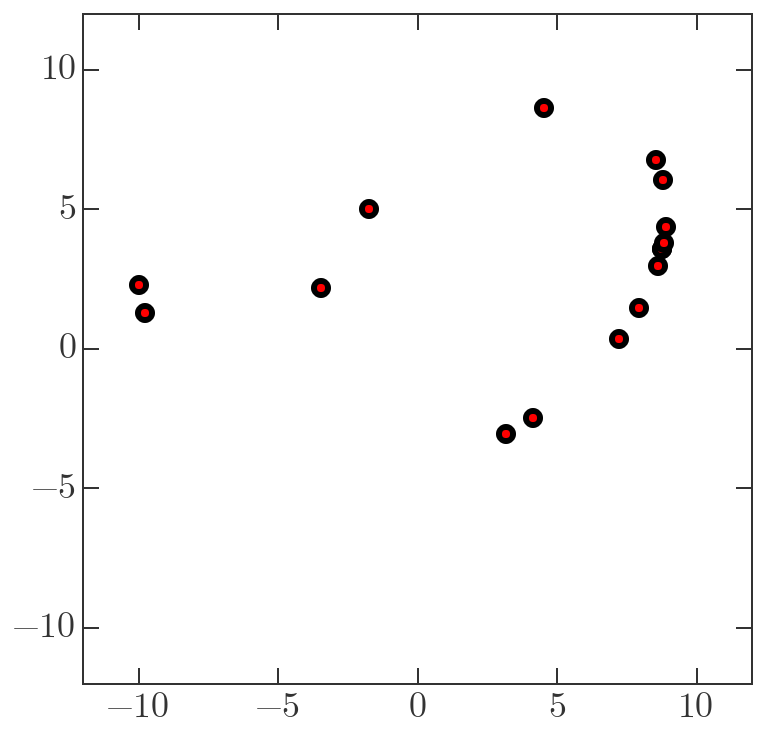

In [166]:
# (chisq_nk.min(axis=1) < ).sum()
ix = chisq_nk.argmin(axis=1)

pl.figure(figsize=(6,6))
for i,j in enumerate(ix):
    this_X_obs = X_obs[i]
    this_X = mock.X[j]
    
    pl.plot(this_X[0], this_X[2], marker='o', color='k', ms=10)
    pl.plot(this_X_obs[0], this_X_obs[2], marker='o', color='r', ms=4)

pl.xlim(-12,12)
pl.ylim(-12,12)